In [1]:
# %load_ext autoreload
# %autoreload 2
import os
import sys
sys.path.append("/Users/steeeve/Documents/GMU/GGS590/Final_Project")

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch 
import ee
import pandas as pd
from MappingCropField import extract_metadata, generate_delineation, display_assigned_field

In [2]:
# Ensure the newest version is installed
# Since the parameter pattern changed for osmnx on 2.0.0
%pip install --upgrade pyproj osmnx --quiet 

Note: you may need to restart the kernel to use updated packages.


##### Config

In [3]:
config = {"all_img_path": "/Users/steeeve/Documents/GMU/GGS590/Final_Project/data/all_sv_imgs",
          "color_composite": "true_color", # Pick between true_color and false_color
          "save_path": "/Users/steeeve/Documents/GMU/GGS590/Final_Project/sent2/",
          "credential_path": "/Users/steeeve/Documents/GMU/GGS590/Final_Project/hanxli_creds.json",
          "label_csv_path": "/Users/steeeve/Documents/GMU/GGS590/Final_Project/data/csiss_imgs.csv",
          "folder_id": "1iwSPV5D05rA9T2TdQ9gy9ED5UDimLpNA" # Folder ID from Google Drive Folder Address
          }

##### Extracting Metadata from Geotagged Images

In [4]:
meta_df = extract_metadata(config["all_img_path"])
meta_df.head(3)

,filename,img_path,altitude,direction,time,geometry
0,IMG_2022_176.jpg,../data/all_sv_imgs/IMG_2022_176.jpg,420.764783,91.784451,2022:08:09 15:20:29,POINT (-96.614 40.697)
1,IMG_2023_365.jpg,../data/all_sv_imgs/IMG_2023_365.jpg,622.166723,248.346314,2023:10:14 14:08:05,POINT (-98.769 40.771)
2,IMG_2023_403.jpg,../data/all_sv_imgs/IMG_2023_403.jpg,337.280145,183.725876,2023:10:15 11:12:46,POINT (-96.18 40.473)


In [5]:
label_df = pd.read_csv(config["label_csv_path"], index_col=0)
label_df.head(3)

,img_name,timestamp,crop_type,save_path,geometry
0,IMG_2022_001.jpg,2022-08-09 13:54:08,Maize,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,POINT (-134842.93178947328 1983715.3378369794)
1,IMG_2022_003.jpg,2022-08-09 13:54:20,Soybean,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,POINT (-134401.7644465734 1983428.4774710557)
2,IMG_2022_004.jpg,2022-08-09 14:48:06,Soybean,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,POINT (-134291.47027611607 1983356.61060757)


In [6]:
label_subset = label_df[["img_name", "crop_type"]]

# Merge df1 with the subset of df2 based on filename (df1) and img_name (df2)
meta_df = pd.merge(meta_df, label_subset, left_on="filename", right_on="img_name", how="left", suffixes=("_meta", "_label"))

# Drop the redundant img_name column
meta_df = meta_df.drop(columns=["img_name"])

# Display the updated DataFrame
meta_df = meta_df.dropna(subset=["crop_type"]).reset_index(drop=True)
meta_df.head(3)

,filename,img_path,altitude,direction,time,geometry,crop_type
0,IMG_2023_365.jpg,../data/all_sv_imgs/IMG_2023_365.jpg,622.166723,248.346314,2023:10:14 14:08:05,POINT (-98.769 40.771),Maize
1,IMG_2023_403.jpg,../data/all_sv_imgs/IMG_2023_403.jpg,337.280145,183.725876,2023:10:15 11:12:46,POINT (-96.18 40.473),Maize
2,IMG_2023_417.jpg,../data/all_sv_imgs/IMG_2023_417.jpg,361.880265,188.567879,2023:10:15 11:23:28,POINT (-96.18 40.315),Other


##### Spatial processing

In [7]:
ee.Authenticate()
ee.Initialize(project="ee-hanxli")

In [9]:
generate_delineation(meta_df[0:1], 
                     color_composite = config["color_composite"], 
                     save_path = config["save_path"],
                     credentials_file_path = config["credential_path"],
                     folder_id = config["folder_id"],
                     visualize = True)

100%|██████████| 1/1 [00:31<00:00, 31.36s/it]


Map(center=[40.77096866081975, -98.76884444444443], controls=(WidgetControl(options=['position', 'transparent_…

100%|██████████| 1/1 [00:32<00:00, 32.07s/it]


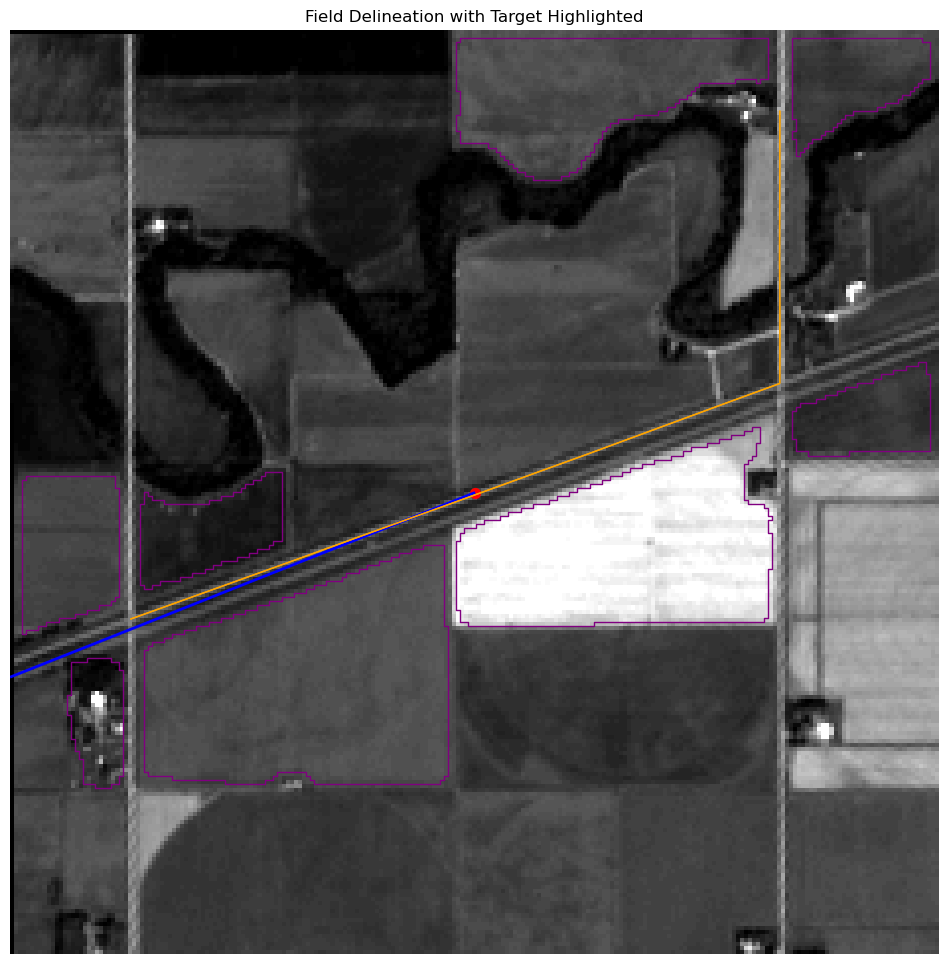

No intersected shapes found. Returning an empty GeoDataFrame.


In [8]:
meta_subset = meta_df[0:1].reset_index(drop=True)
lbl_bounds = display_assigned_field(meta_subset,
                                    color_composite = config["color_composite"], 
                                    save_path = config["save_path"],
                                    credentials_file_path = config["credential_path"],
                                    folder_id = config["folder_id"],
                                    batch_process=False)